# Time Series Prediction Model.
#### The purpose of this notebook is to extract time series data to train a failure prediction model (XGboost), compare its prediction result and value with an outdated prediction model (Random Forest), and replace models if needed

# Load Data

In [5]:
### Load Equipment Failure Data from Microsoft SQL Server and save  

In [2]:
driver = "com.microsoft.sqlserver.jdbc.SQLServerDriver"
url = dbutils.secrets.get('ODS-Integration-KV','ODS-ConnectionString')

table1 = """(
select 
[pranumber]
,[caldate]
,[wellname]
,[x_grosspumpstroke_std]
,[x_tubpres_std]
,[x_pumpfil_std]
,[x_fluidload_std]
,[x_curinfprod_std]
,[x_pumphp_std]
,[x_maxrodload_std]
,[x_mprl_std]
,[x_avgpprl_std]
,[x_fluidloadonpump_std]
,[x_pumpefficiency_std]
,[xGrossPumpStrokeFlag]
,[xTubingPressureFlag]
,[xPumpFillageFlag]
,[xFluidLoadFlag]
,[xCurInfProdFlag]
,[xMaxRodLoadFlag]
,[xMPRLFlag]
,[xPPRLFlag]
,[xFluidLoadOnPumpFlag]
,[xPumpEfficiencyFlag]
,[xPumpHPFlag]
,case when f.failure_date is not null and Equipment_Failure_type = 'Tubing' THEN 1 ELSE 0 END as flag_2days
,case when f.failure_date is not null  then 1 ELSE 0 END failure_flag_all
,case when Equipment_Failure_type = 'Tubing' and abs(datediff(hour,m.caldate,f.failure_date)) <=12 then 1 else 0 end as flag
,cast(f.failure_Date as date) as Failure_2_days
,case when cast(f.failure_Date as date) = cast(caldate as date) then 1 else 0 end as AnyFailureDay

from [ana_ops].[TLF_ML_InputDataset_Diag] m

left join (
select distinct pra_NO, Failure_Date, Equipment_Failure_type from [ana_ops].[v_wv_nd_wellfailure] 
where record_type = 'Primary') f on f.pra_no = m.pranumber and abs(datediff(day,m.caldate,f.failure_date)) <=2

left join (
select distinct pra_NO, Failure_Date as failure_range from [ana_ops].[v_wv_nd_wellfailure] 
where record_type = 'Primary') fw on fw.pra_no = m.pranumber and abs(datediff(day,m.caldate,fw.failure_range)) <= 30

where m.producingmethod = 'PR - PUMPING ROD' and m.district like 'North D%'and(datepart(hour,m.caldate) % 12 = 0 or fw.failure_range is not null)
) foo"""

spark.conf.set("spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation","false")

table1 = spark.read.format("jdbc")\
  .option("driver", driver)\
  .option("url", url)\
  .option("dbtable", table1)\
  .load()
table1.write.format("parquet").saveAsTable("TL_Retrain_Input", mode = 'overwrite')

In [3]:
### converting to pandas dataframe 
df = spark.sql('select * from TL_Retrain_Input')
df = df.toPandas()

# Package Import and Functions

In [5]:
### standard data processing packages
import pandas as pd
import pickle
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [6]:
### model preparation and modeling packages
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import shap

In [1]:
# customized scoring function for grid search cost/value
def my_scorer(clf, X, Y):
    y_pred_proba = clf.predict_proba(X)[:, 1]  
    value = 0
    y_true = Y[:,].tolist()
    for index in range(len(y_pred_proba)):
        # print(index)
        if y_true[index] == 0 and y_pred_proba[index] == 0:
            value -= 0 # Reducing cost by x_amt
        elif y_true[index] == 0 and y_pred_proba[index] == 1:
            value += fp_cost  # Wrong classification adds cost
        elif y_true[index] == 1 and y_pred_proba[index] == 0:
            value += 0 # Wrong classification adds cost and fee
        elif y_true[index] == 1 and y_pred_proba[index] == 1:
            value += 6600  # No cost
        else:
            value += 0
    return value

# New Model - XGBoost Implementation (Post Iteration)

## Preprare data for training

In [9]:
df= df.set_index(['wellname','pranumber','caldate'],drop=False)
df = df.sort_index()

In [12]:
# identify equipment currenting running witout a failure
df.Failure_2_days = df.groupby(df.index.get_level_values(0)).Failure_2_days.bfill().fillna('Current Run')

In [13]:
print(df.Failure_2_days)
print(df.shape)

wellname pranumber caldate 
3WX 3-1H 015512 2016-02-16 00:00:00 Current Run
 2016-02-16 12:00:00 Current Run
 2016-02-17 00:00:00 Current Run
 2016-02-17 12:00:00 Current Run
 2016-02-18 00:00:00 Current Run
 ... 
WING 9-1H 013615 2020-07-11 12:00:00 Current Run
 2020-07-12 00:00:00 Current Run
 2020-07-12 12:00:00 Current Run
 2020-07-13 00:00:00 Current Run
 2020-07-13 12:00:00 Current Run
Name: Failure_2_days, Length: 6867362, dtype: object
Out[62]: (6867362, 30)

In [14]:
#remove any null rows
df = df.dropna()
df.shape

Out[63]: (5023756, 30)

In [15]:
# set 0/1 target flag
df['TestDataSet'] =  0 
df.loc[(pd.to_datetime(df['caldate']) - pd.to_datetime('today') > '-120 days +00:00:00'), 'TestDataSet'] = 1  

In [16]:
# identify input feature columns
input_cols = ['x_grosspumpstroke_std',
       'x_tubpres_std', 'x_pumpfil_std', 'x_fluidload_std', 'x_curinfprod_std',
       'x_pumphp_std', 'x_maxrodload_std', 'x_mprl_std', 'x_avgpprl_std',
       'x_fluidloadonpump_std', 'x_pumpefficiency_std', 'xGrossPumpStrokeFlag',
       'xTubingPressureFlag', 'xPumpFillageFlag', 'xFluidLoadFlag',
       'xCurInfProdFlag', 'xMaxRodLoadFlag', 'xMPRLFlag', 'xPPRLFlag',
       'xFluidLoadOnPumpFlag', 'xPumpEfficiencyFlag', 'xPumpHPFlag']

In [18]:
# prepare training and testing data
X = df[df.TestDataSet == 0][input_cols]
Y = df[df.TestDataSet == 0]['flag']


print(len(Y))
print(sum(Y))

X = X.loc[:,~X.columns.duplicated()]
X = X.astype(np.float32)
Y = Y.astype(np.float32)

train_len = int(len(X) * 0.7)
X_train = X.iloc[:train_len]
X_test = X.iloc[train_len:]
y_train = Y.iloc[:train_len]
y_test = Y.iloc[train_len:]

## apply sampling technique 
sampling_strategy=0.5
ros = RandomUnderSampler(sampling_strategy)

x_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)
X_train_s = pd.DataFrame(x_train_ros, columns = input_cols)

print(len(X_train))
print(len(x_train_ros))
print(sum(y_train))

4638588
28917
Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
3247011
61371
20457.0

In [20]:
### define economic cost and value for grid search scoring
tp_value=6600
fp_cost=-2000

## Grid Search for Hyperparameter Tuning

In [22]:
### define grid search parameters, using kfold 5
def grid_search_xgboost(useful_columns,n_splits=5):
    param_grid = {"learning_rate"    : [0.1] ,
         "max_depth"        : [3,4,5,6],
         "min_child_weight" : [3,4,5,6],
         "gamma"            : [0.2],
         "random_state" : [1]  }

    X = X_train_s
    Y = y_train_ros
    groups = X.index.get_level_values(0)
    model = XGBClassifier(n_estimators=100)
    clf = GridSearchCV(model
                       , param_grid
                       , scoring=my_scorer
#                        , scoring="f1"
                       , verbose = 1
                       , n_jobs = 2
                       , cv=GroupKFold(n_splits=5).get_n_splits(X, Y, groups))
    clf.fit(X, Y)
    return clf
  
clat = grid_search_xgboost(input_cols)

print(clat.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 46 tasks | elapsed: 53.1s
[Parallel(n_jobs=2)]: Done 80 out of 80 | elapsed: 1.8min finished
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
 importance_type='gain', interaction_constraints='',
 learning_rate=0.1, max_delta_step=0, max_depth=3,
 min_child_weight=3, missing=nan, monotone_constraints='()',
 n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
 reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
 tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
xgb = clat.best_estimator_

### Train Model and Save

In [24]:
### model train using best estimator from grid search and save to filestore
model = xgb.fit(X_train_s[input_cols], y_train_ros, verbose = True)

In [25]:
pickle.dump(model, (open('/dbfs/FileStore/tubleak/TubingLeakModelRetrain_XGB_v4_auto_latestbatch.p', "wb")))  

In [26]:
model = pickle.load(open('/dbfs/FileStore/tubleak/TubingLeakModelRetrain_XGB_v4_auto_latestbatch.p', "rb"))

## Model Evaluation and Interpretation

### Model Result Preparation

In [27]:
fi = pd.DataFrame()
#save feature importance
fi['imp'] = model.feature_importances_
fi['feature name'] = input_cols
with pd.option_context('display.max_rows', None, 'display.max_columns', None):print(fi.sort_values(by=['imp'],ascending=False))

imp feature name
9 0.321393 x_fluidloadonpump_std
0 0.159992 x_grosspumpstroke_std
6 0.143821 x_maxrodload_std
4 0.085489 x_curinfprod_std
3 0.072138 x_fluidload_std
2 0.066264 x_pumpfil_std
1 0.058265 x_tubpres_std
7 0.029932 x_mprl_std
10 0.024886 x_pumpefficiency_std
5 0.020064 x_pumphp_std
8 0.017755 x_avgpprl_std
16 0.000000 xMaxRodLoadFlag
20 0.000000 xPumpEfficiencyFlag
19 0.000000 xFluidLoadOnPumpFlag
18 0.000000 xPPRLFlag
17 0.000000 xMPRLFlag
11 0.000000 xGrossPumpStrokeFlag
15 0.000000 xCurInfProdFlag
14 0.000000 xFluidLoadFlag
13 0.000000 xPumpFillageFlag
12 0.000000 xTubingPressureFlag
21 0.000000 xPumpHPFlag

In [29]:
testdataset = df[df.TestDataSet == 1][input_cols].reset_index(drop = True)
pred_proba = model.predict_proba(testdataset[input_cols])[:, 1]
result = df[df.TestDataSet == 1]

In [30]:
result['Pred_prob'] = pred_proba
result['caldate_date'] = pd.to_datetime(result['caldate']).dt.date

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [31]:
result = result.reset_index(drop = True)
test = pd.DataFrame(result.groupby(['pranumber','caldate_date'])['Pred_prob'].mean())
test['flag_2days'] = result.groupby(['pranumber','caldate_date'])['flag_2days'].max()
test['flag'] = result.groupby(['pranumber','caldate_date'])['flag'].max()
test['wellname'] = result.groupby(['pranumber','caldate_date'])['wellname'].first()
test['pranumber'] = result.groupby(['pranumber','caldate_date'])['pranumber'].first()
test['Failure_2_days'] = result.groupby(['pranumber','caldate_date'])['Failure_2_days'].first()
test['failure_flag_all'] = result.groupby(['pranumber','caldate_date'])['failure_flag_all'].first()
test['caldate'] = result.groupby(['pranumber','caldate_date'])['caldate'].first()
test['AnyFailureDay'] = result.groupby(['pranumber','caldate_date'])['AnyFailureDay'].max()
test['month'] = pd.DatetimeIndex(test['caldate']).month
test['Pred_Threshold'] = 0
del fi, testdataset, result

### Best Threshold Sweep for Optimized Economical Value

In [32]:
#create unique identifier for pra number failing and pra number failing flag
test['pranfail'] = test['wellname'].astype(str) + test['Failure_2_days'].astype(str)+test['caldate'].astype(str)
test['pranfail_f'] = test['wellname'].astype(str) + test['Failure_2_days'].astype(str)

#run best threshold sweeping based on economic value and cost
BestThreshold = 0
BestValue = 0 
BestTP = 0
BestFP = 0
TotalPrediction = 0
tp_value=6600  ### previously used in ln(20)
fp_cost=-2000
sweep = pd.DataFrame(columns = ['Threshold','Total Failure Caught','Total False Alert Days','value'])
a = []
b = []
c = []
d = []

for i in range (50,97,1):
    test['Pred_Threshold'] = 0
    Threshold = i/100
    test.loc[(test.Pred_prob >= Threshold), 'Pred_Threshold'] = 1  
    TP = test[(test.flag_2days == 1) & (test.Pred_Threshold == 1)].pranfail.nunique()
    FP = test[(test.AnyFailureDay == 0) & (test.Pred_Threshold == 1)].pranfail.nunique()
    
    test['Truesum'] = 0 
    test['trued'] = 0
    test['caldate'] = pd.to_datetime(test['caldate']).dt.date
    test.loc[(test.failure_flag_all == 1) & (test.Pred_Threshold == 1),'Truesum'] = 1
    test.loc[(test.AnyFailureDay == 1) & (test.Pred_Threshold == 1),'trued'] = 1
    Truesum = test['Truesum'].sum()
    trued = test['trued'].sum()

    FailureCaught = test[(test.failure_flag_all == 1) & (test.Pred_Threshold == 1)].pranfail_f.nunique()
    FalseAlertDays = test[(test.failure_flag_all == 0) & (test.Pred_Threshold == 1)].pranfail.nunique()
    print('Threshold at 0.', i,'Total Failure Caught: ', FailureCaught,'Total False Alert Days: ', FalseAlertDays,'value: ',FailureCaught*tp_value+FalseAlertDays*fp_cost)

    value =FailureCaught*tp_value+FalseAlertDays*fp_cost
    a.append(i)
    b.append(FailureCaught)
    c.append(FalseAlertDays)
    d.append(FailureCaught*tp_value+FalseAlertDays*fp_cost)

    if value >= BestValue:
        BestThreshold = Threshold
        BestValue = value
        BestTP = TP
        BestFP = FP
        TotalPrediction = TP+FP

print('Best:',BestThreshold,BestTP,BestFP,TotalPrediction)

Threshold at 0. 50 Total Failure Caught: 159 Total False Alert Days: 1190 value: -1330600
Threshold at 0. 51 Total Failure Caught: 157 Total False Alert Days: 1134 value: -1231800
Threshold at 0. 52 Total Failure Caught: 157 Total False Alert Days: 1086 value: -1135800
Threshold at 0. 53 Total Failure Caught: 157 Total False Alert Days: 1043 value: -1049800
Threshold at 0. 54 Total Failure Caught: 156 Total False Alert Days: 990 value: -950400
Threshold at 0. 55 Total Failure Caught: 154 Total False Alert Days: 941 value: -865600
Threshold at 0. 56 Total Failure Caught: 154 Total False Alert Days: 907 value: -797600
Threshold at 0. 57 Total Failure Caught: 151 Total False Alert Days: 858 value: -719400
Threshold at 0. 58 Total Failure Caught: 150 Total False Alert Days: 812 value: -634000
Threshold at 0. 59 Total Failure Caught: 148 Total False Alert Days: 774 value: -571200
Threshold at 0. 60 Total Failure Caught: 147 Total False Alert Days: 738 value: -505800
Threshold at 0. 61 Total Failure Caught: 146 Total False Alert Days: 708 value: -452400
Threshold at 0. 62 Total Failure Caught: 146 Total False Alert Days: 670 value: -376400
Threshold at 0. 63 Total Failure Caught: 145 Total False Alert Days: 651 value: -345000
Threshold at 0. 64 Total Failure Caught: 142 Total False Alert Days: 629 value: -320800
Threshold at 0. 65 Total Failure Caught: 141 Total False Alert Days: 612 value: -293400
Threshold at 0. 66 Total Failure Caught: 139 Total False Alert Days: 590 value: -262600
Threshold at 0. 67 Total Failure Caught: 138 Total False Alert Days: 561 value: -211200
Threshold at 0. 68 Total Failure Caught: 135 Total False Alert Days: 532 value: -173000
Threshold at 0. 69 Total Failure Caught: 134 Total False Alert Days: 514 value: -143600
Threshold at 0. 70 Total Failure Caught: 133 Total False Alert Days: 488 value: -98200
Threshold at 0. 71 Total Failure Caught: 131 Total False Alert Days: 456 value: -47400
Threshold at 0. 72 Total Failure Caught: 129 Total False Alert Days: 430 value: -8600
Threshold at 0. 73 Total Failure Caught: 127 Total False Alert Days: 399 value: 40200
Threshold at 0. 74 Total Failure Caught: 127 Total False Alert Days: 362 value: 114200
Threshold at 0. 75 Total Failure Caught: 124 Total False Alert Days: 327 value: 164400
Threshold at 0. 76 Total Failure Caught: 123 Total False Alert Days: 306 value: 199800
Threshold at 0. 77 Total Failure Caught: 120 Total False Alert Days: 282 value: 228000
Threshold at 0. 78 Total Failure Caught: 118 Total False Alert Days: 259 value: 260800
Threshold at 0. 79 Total Failure Caught: 115 Total False Alert Days: 236 value: 287000
Threshold at 0. 80 Total Failure Caught: 112 Total False Alert Days: 208 value: 323200
Threshold at 0. 81 Total Failure Caught: 106 Total False Alert Days: 193 value: 313600
Threshold at 0. 82 Total Failure Caught: 105 Total False Alert Days: 175 value: 343000
Threshold at 0. 83 Total Failure Caught: 100 Total False Alert Days: 151 value: 358000
Threshold at 0. 84 Total Failure Caught: 94 Total False Alert Days: 129 value: 362400
Threshold at 0. 85 Total Failure Caught: 91 Total False Alert Days: 121 value: 358600
Threshold at 0. 86 Total Failure Caught: 85 Total False Alert Days: 106 value: 349000
Threshold at 0. 87 Total Failure Caught: 78 Total False Alert Days: 93 value: 328800
Threshold at 0. 88 Total Failure Caught: 70 Total False Alert Days: 74 value: 314000
Threshold at 0. 89 Total Failure Caught: 64 Total False Alert Days: 62 value: 298400
Threshold at 0. 90 Total Failure Caught: 60 Total False Alert Days: 51 value: 294000
Threshold at 0. 91 Total Failure Caught: 48 Total False Alert Days: 41 value: 234800
Threshold at 0. 92 Total Failure Caught: 41 Total False Alert Days: 34 value: 202600
Threshold at 0. 93 Total Failure Caught: 38 Total False Alert Days: 25 value: 200800
Threshold at 0. 94 Total Failure Caught: 32 Total False Alert Days: 20 value: 171200
Threshold at 0. 95 Total Failure Caught: 21 Total False Alert Days: 8 value: 1

In [33]:
# print sweep results 
sweep = pd.DataFrame({'Threshold': a, 'Total Failure Caught': b,'Total False Alert Days': c,'value': d})
sweep

,Threshold,Total Failure Caught,Total False Alert Days,value
0,50,159,1190,-1330600
1,51,157,1134,-1231800
2,52,157,1086,-1135800
3,53,157,1043,-1049800
4,54,156,990,-950400
5,55,154,941,-865600
6,56,154,907,-797600
7,57,151,858,-719400
8,58,150,812,-634000
9,59,148,774,-571200


In [34]:
print(BestThreshold,BestValue,BestTP,BestFP,TotalPrediction)
print('Value per prediction :', BestValue/TotalPrediction) 

0.84 362400 54 242 296
Value per prediction : 1224.3243243243244

In [35]:
# save best threshold result
test['Pred_Threshold'] = 0
Threshold = BestThreshold
test.loc[(test.Pred_prob >= Threshold), 'Pred_Threshold'] = 1

### Model Result for Well Level and Daily Comparison

In [36]:
# evulate result at daily and well level for score card
DailyLevel = test.reset_index(drop = True)
DailyLevel['month'] = pd.DatetimeIndex(DailyLevel['caldate']).month
WL = pd.DataFrame(DailyLevel.groupby(['pranumber','Failure_2_days'])['Failure_2_days'].first())
WL['failure_flag_all'] = DailyLevel.groupby(['pranumber','Failure_2_days'])['failure_flag_all'].max()
WL['flag_2days'] = DailyLevel.groupby(['pranumber','Failure_2_days'])['flag_2days'].max()
WL['flag'] = DailyLevel.groupby(['pranumber','Failure_2_days'])['flag'].max()
WL['AnyFailureDay'] = DailyLevel.groupby(['pranumber','Failure_2_days'])['AnyFailureDay'].max()
WL['wellname'] = DailyLevel.groupby(['pranumber','Failure_2_days'])['wellname'].first()
WL['Pred_Threshold'] = DailyLevel.groupby(['pranumber','Failure_2_days'])['Pred_Threshold'].max()
WL['month'] = DailyLevel.groupby(['pranumber','Failure_2_days'])['month'].last()
WL['TP'] = 0
WL['FP'] = 0

In [37]:
# calculate true and false postive based on customized requirement
df['pranfail'] = df['pranumber'].astype(str) + df['Failure_2_days'].astype(str)
print(df.pranfail.nunique())

WL['pranfail'] = WL['wellname'].astype(str) + WL['Failure_2_days'].astype(str)
print('Total Failure+Well ',WL.pranfail.nunique())
print('Total Failure ',WL[WL.failure_flag_all == 1].pranfail.nunique())
TP = WL[(WL.failure_flag_all == 1) & (WL.Pred_Threshold == 1)].pranfail.nunique()
FP = WL[(WL.failure_flag_all == 0) & (WL.Pred_Threshold == 1)].pranfail.nunique()
print('Total Failure Caught', WL[(WL.failure_flag_all == 1) & (WL.Pred_Threshold == 1)].pranfail.nunique())
print('Total False Alert', WL[(WL.failure_flag_all == 0) & (WL.Pred_Threshold == 1)].pranfail.nunique())

print('Total Tubing Failure +-48hr ',WL[WL.flag_2days == 1].pranfail.nunique())
TP = WL[(WL.flag_2days == 1) & (WL.Pred_Threshold == 1)].pranfail.nunique()
FP = WL[(WL.flag_2days == 0) & (WL.Pred_Threshold == 1)].pranfail.nunique()
print('Total Failure Caught', WL[(WL.flag_2days == 1) & (WL.Pred_Threshold == 1)].pranfail.nunique())
print('Total False Alert', WL[(WL.flag_2days == 0) & (WL.Pred_Threshold == 1)].pranfail.nunique())


4135
Total Failure+Well 1258
Total Failure 288
Total Failure Caught 110
Total False Alert 54
Total Tubing Failure +-48hr 50
Total Failure Caught 30
Total False Alert 134

In [38]:
# calculate score card at a daily level based on customized requirement
DailyLevel['pranfail'] = DailyLevel['wellname'].astype(str) + DailyLevel['Failure_2_days'].astype(str)+DailyLevel['caldate'].astype(str)
DailyLevel['pranfail_f'] = DailyLevel['wellname'].astype(str) + DailyLevel['Failure_2_days'].astype(str)
print('Total Failure+Well days ',DailyLevel.pranfail.nunique())
print('Total Failure Days ',DailyLevel[DailyLevel.failure_flag_all == 1].pranfail.nunique())
TP = DailyLevel[(DailyLevel.failure_flag_all == 1) & (DailyLevel.Pred_Threshold == 1)].pranfail.nunique()
FP = DailyLevel[(DailyLevel.failure_flag_all == 0) & (DailyLevel.Pred_Threshold == 1)].pranfail.nunique()
print('Total Failure Caught', DailyLevel[(DailyLevel.failure_flag_all == 1) & (DailyLevel.Pred_Threshold == 1)].pranfail.nunique())
print('Total Failure Caught_failurelevel', DailyLevel[(DailyLevel.failure_flag_all == 1) & (DailyLevel.Pred_Threshold == 1)].pranfail_f.nunique())
print('Total False Alert', DailyLevel[(DailyLevel.failure_flag_all == 0) & (DailyLevel.Pred_Threshold == 1)].pranfail.nunique())
print('Total False Alert_failurelevel', DailyLevel[(DailyLevel.failure_flag_all == 0) & (DailyLevel.Pred_Threshold == 1)].pranfail_f.nunique())

print('Total Tubing Failure Days +- 48hr ',DailyLevel[DailyLevel.flag_2days == 1].pranfail.nunique())
TP = DailyLevel[(DailyLevel.flag_2days == 1) & (DailyLevel.Pred_Threshold == 1)].pranfail.nunique()
FP = DailyLevel[(DailyLevel.flag_2days == 0) & (DailyLevel.Pred_Threshold == 1)].pranfail.nunique()
print('Total Tubing Failure Caught', DailyLevel[(DailyLevel.flag_2days == 1) & (DailyLevel.Pred_Threshold == 1)].pranfail.nunique())
print('Total Tubing Failure Caught_failurelevel', DailyLevel[(DailyLevel.flag_2days == 1) & (DailyLevel.Pred_Threshold == 1)].pranfail_f.nunique())
print('Total Tubing False Alert', DailyLevel[(DailyLevel.flag_2days == 0) & (DailyLevel.Pred_Threshold == 1)].pranfail.nunique())
print('Total Tubing False Alert_failurelevel', DailyLevel[(DailyLevel.flag_2days == 0) & (DailyLevel.Pred_Threshold == 1)].pranfail_f.nunique())

Total Failure+Well days 98046
Total Failure Days 1136
Total Failure Caught 168
Total Failure Caught_failurelevel 94
Total False Alert 129
Total False Alert_failurelevel 77
Total Tubing Failure Days +- 48hr 193
Total Tubing Failure Caught 54
Total Tubing Failure Caught_failurelevel 27
Total Tubing False Alert 243
Total Tubing False Alert_failurelevel 140

In [39]:
##### False alert days calculation. If predicted 1, actual 0, and predictded more than 4 days prior to failure than false alert day
DailyLevel['allFailure_rol'] = DailyLevel.groupby(['wellname'])['failure_flag_all'].shift(-2)
print(DailyLevel[(DailyLevel.failure_flag_all == 0) & (DailyLevel.Pred_Threshold == 1) & (DailyLevel.allFailure_rol == 0)].pranfail.nunique())

95

### New Model Score Card for Comparison

In [40]:
ModelScore = pd.DataFrame(data = ['NewModel'])

In [41]:
#Summarize New Model Results and Value
print(BestThreshold,BestValue,BestTP,BestFP,TotalPrediction)


ModelScore['Best Threshhold'] = BestThreshold
ModelScore['TotalPrediction'] = TotalPrediction
#### True prediction if predicted 1, actual (+/- 2 days) is 0 at a well/failure level. 

ModelScore['TotalFailure'] = WL[WL.failure_flag_all == 1].pranfail.nunique()

##### False alert days calculation. If predicted 1, actual 0, and predictded more than 4 days prior to failure than false alert day
ModelScore['TrueFailurePredicted'] =  DailyLevel[(DailyLevel.failure_flag_all == 1) & (DailyLevel.Pred_Threshold == 1)].pranfail_f.nunique()

ModelScore['FalseAlertDays'] = DailyLevel[(DailyLevel.failure_flag_all == 0) & (DailyLevel.Pred_Threshold == 1) & (DailyLevel.allFailure_rol == 0)].pranfail.nunique()
ModelScore['Value'] = ModelScore['TrueFailurePredicted']* 6600 + ModelScore['TrueFailurePredicted']*-2200
ModelScore['TestStartDate'] =  DailyLevel.caldate.min()
ModelScore['TestStartDate'] =  DailyLevel.caldate.max()
print(ModelScore)

0.84 362400 54 242 296
 0 Best Threshhold ... Value TestStartDate
0 NewModel 0.84 ... 413600 2020-07-13

[1 rows x 8 columns]

### Feature Importance Overview

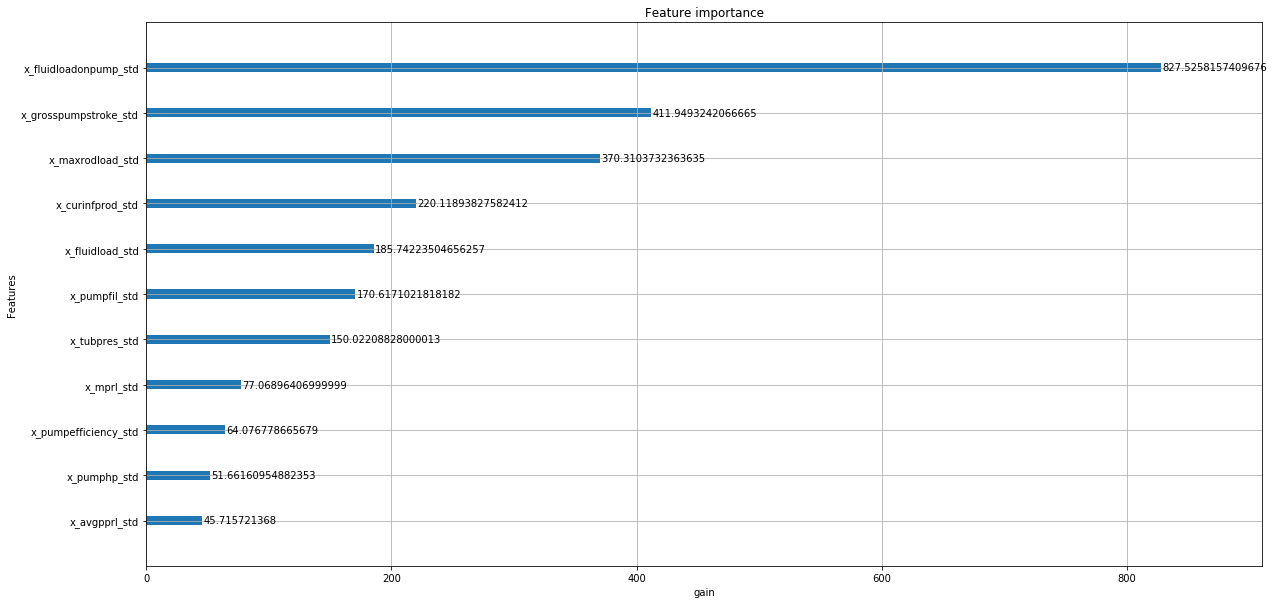

In [42]:
# Interpret and Present Feature Importance of the Model
fig, ax = plt.subplots(1,1,figsize=(20,10))
gain = xgboost.plot_importance(model, xlabel='gain', importance_type='gain',ax = ax)

# weight = xgboost.plot_importance(model, xlabel= 'weight', importance_type='weight',ax = ax)
# cover = xgboost.plot_importance(model, xlabel= 'cover', importance_type='cover',ax = ax)

# Current Model Result_EBS Signal Score Card From Signals

## Import Data from Microsoft Sql Server

In [47]:
# import current prediction result in database
driver = "com.microsoft.sqlserver.jdbc.SQLServerDriver"
url = dbutils.secrets.get('ODS-Integration-KV','ODS-ConnectionString')

table2 = """(
select m.wellname, 
cast(m.caldate as date) as caldate, 
month(m.caldate) as month, 
m.prob_tlf,
cast(f.failure_date as date) as failure_date,
case when f.failure_date is not null then 1 else 0 end as allFailure,
case when Equipment_Failure_type  = 'Tubing' then 1 else 0 end as TubingFailure,
batch_timestamp
FROM [ana_ops].[v_TLF_ML_Prediction_Diag_EBS] m
left join (
select distinct pra_NO, Failure_Date, Equipment_Failure_type 
from [ana_ops].[v_wv_nd_wellfailure] where record_type = 'Primary' 
) f on f.pra_no = m.pranumber and abs(datediff(day,m.caldate,f.failure_date)) <=2
where datediff(day,m.caldate,getdate()) <= 120
) foo"""

# spark.conf.set("spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation","true")

table2 = spark.read.format("jdbc")\
  .option("driver", driver)\
  .option("url", url)\
  .option("dbtable", table2)\
  .load()

EBS = table2.toPandas()


## Prepare Data for Score Card Calculation

In [48]:
EBS= EBS.set_index(['wellname','batch_timestamp'],drop=False)
EBS = EBS.sort_index()
EBS.failure_date = EBS.groupby(EBS.index.get_level_values(0)).failure_date.bfill().fillna('Current Run')
EBS = EBS.reset_index(drop = True)

In [49]:
EBS = EBS.drop_duplicates(keep='last')

In [50]:
EBS.shape

Out[40]: (2203187, 8)

In [52]:
# calculated required information
EBStest = pd.DataFrame(EBS.groupby(['wellname','caldate'])['prob_tlf'].mean())
EBStest['allFailure'] = EBS.groupby(['wellname','caldate'])['allFailure'].max()
EBStest['failure_date'] = EBS.groupby(['wellname','caldate'])['failure_date'].first()
EBStest['TubingFailure'] = EBS.groupby(['wellname','caldate'])['TubingFailure'].max()
EBStest['wellname'] = EBS.groupby(['wellname','caldate'])['wellname'].first()
EBStest['caldate'] = EBS.groupby(['wellname','caldate'])['caldate'].first()
EBStest['Pred_Threshold'] =0
EBStest.loc[(EBStest.prob_tlf >= 0.89), 'Pred_Threshold'] = 1

In [53]:
EBStest.tail(5)

prob_tlf 
 allFailure 
 failure_date 
 TubingFailure 
 wellname 
 caldate 
 Pred_Threshold 
 
 
 wellname 
 caldate 
 
 
 
 
 
 
 
 
 
 
 
 WEYRAUCH 15-11H 
 2020-06-23 
 0.120577 
 0 
 Current Run 
 0 
 WEYRAUCH 15-11H 
 2020-06-23 
 0 
 
 
 2020-06-24 
 0.131249 
 0 
 Current Run 
 0 
 WEYRAUCH 15-11H 
 2020-06-24 
 0 
 
 
 2020-06-25 
 0.072772 
 0 
 Current Run 
 0 
 WEYRAUCH 15-11H 
 2020-06-25 
 0 
 
 
 2020-07-11 
 0.259912 
 0 
 Current Run 
 0 
 WEYRAUCH 15-11H 
 2020-07-11 
 0 
 
 
 2020-07-13 
 0.678801 
 0 
 Current Run 
 0 
 WEYRAUCH 15-11H 
 2020-07-13 
 0

## Calculate Current Score Card 

In [54]:
# calculate current score with customized TP and FP
EBStest['pranfail'] = EBStest['wellname'].astype(str) + EBStest['failure_date'].astype(str)+EBStest['caldate'].astype(str)
EBStest['pranfail_f'] = EBStest['wellname'].astype(str) + EBStest['failure_date'].astype(str)
print('Total Failure+Well days',EBStest.pranfail.nunique())
print('Total Failure Days ',EBStest[EBStest.allFailure == 1].pranfail.nunique())
TP = EBStest[(EBStest.allFailure == 1) & (EBStest.Pred_Threshold == 1)].pranfail.nunique()
FP = EBStest[(EBStest.allFailure == 0) & (EBStest.Pred_Threshold == 1)].pranfail.nunique()
print('Total Failure Caught', TP)
print('Total Failure Caught_failurelevel', EBStest[(EBStest.allFailure == 1) & (EBStest.Pred_Threshold == 1)].pranfail_f.nunique())
print('Total False Alert', FP)
print('Total False Alert_failurelevel', EBStest[(EBStest.allFailure == 0) & (EBStest.Pred_Threshold == 1)].pranfail_f.nunique())

print('Total Tubing Failure Days +- 48hr ',EBStest[EBStest.TubingFailure == 1].pranfail.nunique())
TP = EBStest[(EBStest.TubingFailure == 1) & (EBStest.Pred_Threshold == 1)].pranfail.nunique()
FP = EBStest[(EBStest.TubingFailure== 0) & (EBStest.Pred_Threshold == 1)].pranfail.nunique()
print('Total Tubing Failure Caught', TP)
print('Total Tubing Failure Caught_failurelevel', EBStest[(EBStest.TubingFailure == 1) & (EBStest.Pred_Threshold == 1)].pranfail_f.nunique())
print('Total Tubing False Alert', FP)
print('Total Tubing False Alert_failurelevel', EBStest[(EBStest.TubingFailure == 0) & (EBStest.Pred_Threshold == 1)].pranfail_f.nunique())


Total Failure+Well days 98929
Total Failure Days 840
Total Failure Caught 78
Total Failure Caught_failurelevel 52
Total False Alert 99
Total False Alert_failurelevel 48
Total Tubing Failure Days +- 48hr 154
Total Tubing Failure Caught 30
Total Tubing Failure Caught_failurelevel 18
Total Tubing False Alert 147
Total Tubing False Alert_failurelevel 81

In [55]:
# calculate score card at a well level
EBStest = EBStest.reset_index(drop = True)
WL = pd.DataFrame(EBStest.groupby(['wellname','failure_date'])['failure_date'].first())
WL['failure_flag_all'] = EBStest.groupby(['wellname','failure_date'])['allFailure'].max()
WL['flag_2days'] = EBStest.groupby(['wellname','failure_date'])['TubingFailure'].max()

WL['caldate'] = EBStest.groupby(['wellname','failure_date'])['caldate'].max()

WL['wellname'] = EBStest.groupby(['wellname','failure_date'])['wellname'].first()
WL['Pred_Threshold'] = EBStest.groupby(['wellname','failure_date'])['Pred_Threshold'].max()
WL['TP'] = 0
WL['FP'] = 0

WL['pranfail'] = WL['wellname'].astype(str) + WL['failure_date'].astype(str)

print('Total Failure+Well',WL.pranfail.nunique())
print('Total All Failure ',WL[WL.failure_flag_all == 1].pranfail.nunique())
WL['TP_all'] = WL[(WL.failure_flag_all == 1) & (WL.Pred_Threshold == 1)].pranfail.nunique()
WL['FP_all'] = WL[(WL.failure_flag_all == 0) & (WL.Pred_Threshold == 1)].pranfail.nunique()
print('Total All Failure Caught', WL[(WL.failure_flag_all == 1) & (WL.Pred_Threshold == 1)].pranfail.nunique())
print('Total All False Alert', WL[(WL.failure_flag_all == 0) & (WL.Pred_Threshold == 1)].pranfail.nunique())
print('Total Tubing Failure ',WL[WL.flag_2days == 1].pranfail.nunique())
WL['TP_tubing'] = WL[(WL.flag_2days == 1) & (WL.Pred_Threshold == 1)].pranfail.nunique()
WL['FP_tubing'] = WL[(WL.flag_2days == 0) & (WL.Pred_Threshold == 1)].pranfail.nunique()
print('Total Tubing Failure Caught', WL[(WL.flag_2days == 1) & (WL.Pred_Threshold == 1)].pranfail.nunique())
print('Total Tubing False Alert', WL[(WL.flag_2days == 0) & (WL.Pred_Threshold == 1)].pranfail.nunique())

Total Failure+Well 1335
Total All Failure 282
Total All Failure Caught 62
Total All False Alert 37
Total Tubing Failure 52
Total Tubing Failure Caught 19
Total Tubing False Alert 80

In [56]:
EBStest['allFailure_rol'] = EBStest.groupby(['wellname'])['allFailure'].shift(-2)
EBStest['FP'] = 0
EBStest.loc[(EBStest.allFailure == 0) & (EBStest.Pred_Threshold == 1),'FP'] = 1
WL['FP_R'] = EBStest.groupby(['wellname','failure_date'])['FP'].sum()

In [57]:
EBSScore = pd.DataFrame(data = ['EBS'])
EBSScore['TotalFailure'] = WL[WL.failure_flag_all == 1].pranfail.nunique()
#### True prediction if predicted 1, actual (+/- 2 days) is 0 at a well/failure level. 
EBSScore['TrueFailurePredicted'] =   WL[(WL.failure_flag_all == 1) & (WL.Pred_Threshold == 1)].pranfail.nunique()
##### False alert days calculation. If predicted 1, actual 0, and predictded more than 4 days prior to failure than false alert day
EBSScore['FalseAlertDays'] = EBStest['FP'].sum()
EBSScore['Value'] = EBSScore['TrueFailurePredicted']* 6600 + EBSScore['FalseAlertDays']*-2200
EBSScore['TestStartDate'] =  EBStest.caldate.min()
EBSScore['TestEndDate'] = EBStest.caldate.max()
print(EBSScore)

0 TotalFailure TrueFailurePredicted ... Value TestStartDate TestEndDate
0 EBS 282 62 ... 191400 2020-03-15 2020-07-13

[1 rows x 7 columns]

In [58]:
EBSScore

,0,TotalFailure,TrueFailurePredicted,FalseAlertDays,Value,TestStartDate,TestEndDate
0,EBS,282,62,99,191400,2020-03-15,2020-07-13


In [59]:
WL

failure_date 
 failure_flag_all 
 flag_2days 
 caldate 
 wellname 
 Pred_Threshold 
 TP 
 FP 
 pranfail 
 TP_all 
 FP_all 
 TP_tubing 
 FP_tubing 
 FP_R 
 
 
 wellname 
 failure_date 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 A. IVERSON 12-13H 
 Current Run 
 Current Run 
 0 
 0 
 2020-04-09 
 A. IVERSON 12-13H 
 0 
 0 
 0 
 A. IVERSON 12-13HCurrent Run 
 62 
 37 
 19 
 80 
 0 
 
 
 ALWIN 13-1H 
 2020-04-27 
 2020-04-27 
 1 
 1 
 2020-04-28 
 ALWIN 13-1H 
 0 
 0 
 0 
 ALWIN 13-1H2020-04-27 
 62 
 37 
 19 
 80 
 0 
 
 
 Current Run 
 Current Run 
 0 
 0 
 2020-07-13 
 ALWIN 13-1H 
 0 
 0 
 0 
 ALWIN 13-1HCurrent Run 
 62 
 37 
 19 
 80 
 0 
 
 
 AN-BOHMBACH-153-94-2734H-1 
 Current Run 
 Current Run 
 0 
 0 
 2020-07-13 
 AN-BOHMBACH-153-94-2734H-1 
 0 
 0 
 0 
 AN-BOHMBACH-153-94-2734H-1Current Run 
 62 
 37 
 19 
 80 
 0 
 
 
 AN-BOHMBACH-153-94-2734H-10 
 Current Run 
 Current Run 
 0 
 0 
 2020-03-29 
 AN-BOHMBACH-153-94-2734H-10 
 0 
 0 
 0 
 AN-BOHMBACH-153-94-2734H-10Current Run 
 62 
 37 
 19 
 80 
 0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 TWILIGHT 1-24H 
 Current Run 
 Current Run 
 0 
 0 
 2020-07-13 
 TWILIGHT 1-24H 
 0 
 0 
 0 
 TWILIGHT 1-24HCurrent Run 
 62 
 37 
 19 
 80 
 0 
 
 
 WAHLSTROM 18-1H 
 Current Run 
 Current Run 
 0 
 0 
 2020-07-13 
 WAHLSTROM 18-1H 
 0 
 0 
 0 
 WAHLSTROM 18-1HCurrent Run 
 62 
 37 
 19 
 80 
 0 
 
 
 WERRE TRUST 29-1H 
 Current Run 
 Current Run 
 0 
 0 
 2020-07-12 
 WERRE TRUST 29-1H 
 0 
 0 
 0 
 WERRE TRUST 29-1HCurrent Run 
 62 
 37 
 19 
 80 
 0 
 
 
 WEYRAUCH 15-11H 
 2020-03-14 
 2020-03-14 
 1 
 1 
 2020-03-15 
 WEYRAUCH 15-11H 
 0 
 0 
 0 
 WEYRAUCH 15-11H2020-03-14 
 62 
 37 
 19 
 80 
 0 
 
 
 Current Run 
 Current Run 
 0 
 0 
 2020-07-13 
 WEYRAUCH 15-11H 
 0 
 0 
 0 
 WEYRAUCH 15-11HCurrent Run 
 62 
 37 
 19 
 80 
 0 
 
 
 
 1335 rows × 14 columns

# Compare Newly Retrained Model Score Card to Current Score Card and Update Model

In [61]:
### compare newly trained model with existing model result based on ECONOMIC VALUE gain
Path = "/dbfs/FileStore/tubleak/TubingLeakModelRetrain_XGB_v4_autoretrain_ModelScore.csv"
print('New Model Value (last 4 months):', ModelScore.Value, 'Current EBS Value (last 4 months): ', EBSScore.Value)

if ModelScore.Value[0] > EBSScore.Value[0]:
    # if new model value is greater than current model version, update model used to new version
    print('Recommend Switch to Newly Trained Model')
    print(ModelScore)
    pickle.dump(model, (open('/dbfs/FileStore/tubleak/TubingLeakModelRetrain_XGB_v3_auto.p', "wb")))
    ModelScore.to_csv('/dbfs/FileStore/tubleak/TubingLeakModelRetrain_XGB_v3_autoretrain_ModelScore.csv')
    result.to_csv('/dbfs/FileStore/tubleak/TubingLeakModelRetrain_XGB_v3_autoretrain_predresult.csv')
  

New Model Value (last 4 months): 0 413600
Name: Value, dtype: int64 Current EBS Value (last 4 months): 0 191400
Name: Value, dtype: int64
Recommend Switch to Newly Trained Model
 0 Best Threshhold ... Value TestStartDate
0 NewModel 0.84 ... 413600 2020-07-13

[1 rows x 8 columns]

In [62]:
## to access ModelScore csv files from web
# https://eastus.azuredatabricks.net/files/tubleak/TubingLeakModelRetrain_XGB_v3_autoretrain_ModelScore.csv?o=5852914501436505

In [63]:
# to access result csv 
# https://eastus.azuredatabricks.net/files/tubleak/TubingLeakModelRetrain_XGB_v3_autoretrain_predresult.csv?o=5852914501436505

In [64]:
## to access DailyLevel csv files from web
# DailyLevel.to_csv('/dbfs/FileStore/tubleak/TubingLeakModelRetrain_XGB_v3_autoretrain_DailyLevel.csv')
# https://eastus.azuredatabricks.net/files/tubleak/TubingLeakModelRetrain_XGB_v3_autoretrain_DailyLevel.csv?o=5852914501436505

In [65]:
## to access test csv files from web
# https://eastus.azuredatabricks.net/files/tubleak/test.csv?o=5852914501436505

In [66]:
## If needed, save sweep csv on file
#sweep.to_csv('/dbfs/FileStore/tubleak/TubingLeakModelRetrain_XGB_v3_ThresholdSweep.csv')
#https://eastus.azuredatabricks.net/files/tubleak/TubingLeakModelRetrain_XGB_v3_ThresholdSweep.csv?o=5852914501436505